## PLINK GWAS QC Tutorial

This is a companion analysis to the Glow QC notebook that enumerates the commands originally run in the pubulication tutorial.

Comments and code from the original tutorial are included with R steps commented out (and replaced by python where necessary).  To disambiguate between comments from the original authors and me, the ```#*#``` character is used as a comment from me while all others are left as-is.

In [1]:
import os.path as osp
import pandas as pd
%run ../../nb.py
gab.register_timeop_magic(get_ipython(), 'plink')
data_dir = TUTORIAL_1_QC_DIR
data_dir

'/home/eczech/data/gwas/tutorial/1_QC_GWAS'

## QC

### Step 1: Sample/Variant Absence Filter

In [ ]:
%%bash -s "$data_dir"
set -e
cd $1

### Step 1 ### 

# Investigate missingness per individual and per SNP and make histograms.
plink --bfile HapMap_3_r3_1 --missing    

# output: plink.imiss and plink.lmiss, these files show respectively the proportion of missing SNPs per individual and the proportion of missing individuals per SNP.

In [7]:
%%timeop -o qc1
%%bash -s "$data_dir"
set -e
cd $1

# Delete SNPs and individuals with high levels of missingness, explanation of this and all following steps can be found in box 1 and table 1 of the article mentioned in the comments of this script.
# The following two QC commands will not remove any SNPs or individuals. However, it is good practice to start the QC with these non-stringent thresholds.  
# Delete SNPs with missingness >0.2.
plink --bfile HapMap_3_r3_1 --geno 0.2 --make-bed --out HapMap_3_r3_2

# Delete individuals with missingness >0.2.
plink --bfile HapMap_3_r3_2 --mind 0.2 --make-bed --out HapMap_3_r3_3

# Delete SNPs with missingness >0.02.
plink --bfile HapMap_3_r3_3 --geno 0.02 --make-bed --out HapMap_3_r3_4

# Delete individuals with missingness >0.02.
plink --bfile HapMap_3_r3_4 --mind 0.02 --make-bed --out HapMap_3_r3_5

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_2.log.
Options in effect:
  --bfile HapMap_3_r3_1
  --geno 0.2
  --make-bed
  --out HapMap_3_r3_2

128535 MB RAM detected; reserving 64267 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997378.
0 variants removed due to missing genotype data (--geno).
1457897 variants and 165 people pass filters and QC.
Among remaining phenotypes, 56 are

commands treat these as missing.
commands treat these as missing.
commands treat these as missing.
commands treat these as missing.


### Step 2: Gender Discrepancy

In [12]:
%%timeop -o qc2
%%bash -s $data_dir
set -e
cd $1 

### Step2 ####

# Check for sex discrepancy.
# Subjects who were a priori determined as females must have a F value of <0.2, and subjects who were a priori determined as males must have a F value >0.8. This F value is based on the X chromosome inbreeding (homozygosity) estimate.
# Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.

plink --bfile HapMap_3_r3_5 --check-sex 

# Generate plots to visualize the sex-check results.
# Rscript --no-save gender_check.R
# These checks indicate that there is one woman with a sex discrepancy, F value of 0.99. (When using other datasets often a few discrepancies will be found). 

# The following two scripts can be used to deal with individuals with a sex discrepancy.
# Note, please use one of the two options below to generate the bfile hapmap_r23a_6, this file we will use in the next step of this tutorial.

# 1) Delete individuals with sex discrepancy.
grep "PROBLEM" plink.sexcheck| awk '{print$1,$2}'> sex_discrepancy.txt
# This command generates a list of individuals with the status ìPROBLEMî.
plink --bfile HapMap_3_r3_5 --remove sex_discrepancy.txt --make-bed --out HapMap_3_r3_6 
# This command removes the list of individuals with the status ìPROBLEMî.

# 2) impute-sex.
plink --bfile HapMap_3_r3_5 --impute-sex --make-bed --out HapMap_3_r3_6
# This imputes the sex based on the genotype information into your data set.

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile HapMap_3_r3_5
  --check-sex

128535 MB RAM detected; reserving 64267 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997899.
1430443 variants and 165 people pass filters and QC.
Among remaining phenotypes, 56 are cases and 56 are controls.  (53 phenotypes
are missing.)
--check-sex: 23424 Xchr and 0 Ychr variant

treat these as missing.
commands treat these as missing.
commands treat these as missing.


Show the samples with sex discrepancies (just one in this case -- NA10854):

In [13]:
%%bash -s $data_dir
cd $1 
#*# See here for field definitions: https://www.cog-genomics.org/plink/1.9/formats#sexcheck
grep "PROBLEM" plink.sexcheck 

   1349   NA10854            2            1      PROBLEM         0.99


### Step 3: Autosomal Variants and MAF Filtering

In [19]:
%%timeop -o qc3
%%bash -s $data_dir
set -e
cd $1 

### Step 3 ### 

# Generate a bfile with autosomal SNPs only and delete SNPs with a low minor allele frequency (MAF).

# Select autosomal SNPs only (i.e., from chromosomes 1 to 22).
awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' HapMap_3_r3_6.bim > snp_1_22.txt
plink --bfile HapMap_3_r3_6 --extract snp_1_22.txt --make-bed --out HapMap_3_r3_7

#*# Ignore this to ensure compatibility of benchmarks
# Generate a plot of the MAF distribution.
# plink --bfile HapMap_3_r3_7 --freq --out MAF_check
# Rscript --no-save MAF_check.R

# Remove SNPs with a low MAF frequency.
plink --bfile HapMap_3_r3_7 --maf 0.05 --make-bed --out HapMap_3_r3_8
# 1073226 SNPs are left
# A conventional MAF threshold for a regular GWAS is between 0.01 or 0.05, depending on sample size.

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_7.log.
Options in effect:
  --bfile HapMap_3_r3_6
  --extract snp_1_22.txt
  --make-bed
  --out HapMap_3_r3_7

128535 MB RAM detected; reserving 64267 MB for main workspace.
1430443 variants loaded from .bim file.
165 people (81 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--extract: 1398544 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99806.
1398544 variants and 165 people pass filters and QC.
Among remaining phenotypes, 56 are cases a

### Step 4: HWE Filtering

**Modifications**: Two of the commands below are modified to use the "midp" adjustment described in the [plink hwe docs](https://www.cog-genomics.org/plink/1.9/filter#hwe).  This option is used instead because the Glow implementation (based on Hail) also does this and because the ```plink``` docs "recommend its use".  

**Important**: Neither the original commands nor the modified version above actually result in any variants being removed!

In [39]:
%%timeop -o qc4
%%bash -s $data_dir
set -e
cd $1 

### Step 4 ###

# Delete SNPs which are not in Hardy-Weinberg equilibrium (HWE).

#*# ORIGINAL: plink --bfile HapMap_3_r3_8 --hardy
plink --bfile HapMap_3_r3_8 --hardy midp
# Selecting SNPs with HWE p-value below 0.00001, required for one of the two plot generated by the next Rscript, allows to zoom in on strongly deviating SNPs. 
awk '{ if ($9 <0.00001) print $0 }' plink.hwe>plinkzoomhwe.hwe
# Rscript --no-save hwe.R

# By default the --hwe option in plink only filters for controls.
# Therefore, we use two steps, first we use a stringent HWE threshold for controls, followed by a less stringent threshold for the case data.
#*# ORIGINAL: plink --bfile HapMap_3_r3_8 --hwe 1e-6 midp --make-bed --out HapMap_hwe_filter_step1
plink --bfile HapMap_3_r3_8 --hwe 1e-6 midp --make-bed --out HapMap_hwe_filter_step1

# The HWE threshold for the cases filters out only SNPs which deviate extremely from HWE. 
# This second HWE step only focusses on cases because in the controls all SNPs with a HWE p-value < hwe 1e-6 were already removed
#*# ORIGINAL: plink --bfile HapMap_hwe_filter_step1 --hwe 1e-10 --hwe-all --make-bed --out HapMap_3_r3_9
plink --bfile HapMap_hwe_filter_step1 --hwe 1e-10 midp include-nonctrl --nonfounders --make-bed --out HapMap_3_r3_9

# Theoretical background for this step is given in our accompanying article: https://www.ncbi.nlm.nih.gov/pubmed/29484742 .

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile HapMap_3_r3_8
  --hardy midp

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
165 people (81 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998047.
--hardy: Writing Hardy-Weinberg report (founders only) to plink.hwe ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566

Show the variants that deviate from HWE (i.e. for p-value on HWE hypothesis < 1e-5):

In [41]:
%%bash -s $data_dir
set -e
cd $1 

#*# plink.hwe contains a number of lines equal to 3 times the number of variants
#*# because statistics for all variants are computed for three separates sets 
#*# of input individuals (controls, cases, and all)
#*# see: https://www.cog-genomics.org/plink/1.9/basic_stats#hardy
#*# NOTE: While all variants below have p < 1e-5, none of the UNAFF group variants clear a 1e-6 filter
awk '{ if ($9 <0.00001) print $0 }' plink.hwe

   2   rs4954599    UNAFF    G    A              11/9/36   0.1607   0.4004    8.831e-06
   3  rs10510224    UNAFF    G    C              10/8/36   0.1481   0.3841    9.568e-06
   3   rs2364367      AFF    G    C             20/12/24   0.2143   0.4974    8.801e-06
   3   rs7623291      ALL    T    C             22/28/62     0.25   0.4362    5.413e-06
   7  rs34238522      ALL    C    T              0/64/48   0.5714   0.4082    2.279e-06
   8   rs1365032      AFF    C    T             23/12/21   0.2143   0.4994    8.656e-06
   8   rs1365031      AFF    G    A             23/12/21   0.2143   0.4994    8.656e-06
   8   rs2016354      AFF    C    T             23/12/21   0.2143   0.4994    8.656e-06
   8   rs2588302      AFF    T    G             20/12/24   0.2143   0.4974    8.801e-06
   8   rs3102841      ALL    C    A              8/78/23   0.7156   0.4905    1.261e-06
   9    rs354831      ALL    C    T             12/18/82   0.1607   0.3047    3.389e-06
   9  rs10990625      ALL    C  

### Step 5: Heterzygosity Filtering

In [8]:
%%timeop -o qc5-gen-hr
%%bash -s $data_dir
set -e
cd $1 

### step 5 ###

# Generate a plot of the distribution of the heterozygosity rate of your subjects.
# And remove individuals with a heterozygosity rate deviating more than 3 sd from the mean.

# Checks for heterozygosity are performed on a set of SNPs which are not highly correlated.
# Therefore, to generate a list of non-(highly)correlated SNPs, we exclude high inversion regions (inversion.txt [High LD regions]) and prune the SNPs using the command --indep-pairwiseí.
# The parameters ë50 5 0.2í stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.

plink --bfile HapMap_3_r3_9 --exclude inversion.txt --range --indep-pairwise 50 5 0.2 --out indepSNP
# Note, don't delete the file indepSNP.prune.in, we will use this file in later steps of the tutorial.

plink --bfile HapMap_3_r3_9 --extract indepSNP.prune.in --het --out R_check
# This file contains your pruned data set.

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to indepSNP.log.
Options in effect:
  --bfile HapMap_3_r3_9
  --exclude inversion.txt
  --indep-pairwise 50 5 0.2
  --out indepSNP
  --range

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
165 people (81 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--exclude range: 9893 variants excluded.
--exclude range: 1063333 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 d

The tutorial publication suggests that the outliers now be selected in R based on the heterozygosity statistics produced above.  Specifically, it states:

```
# Plot of the heterozygosity rate distribution
Rscript --no-save check_heterozygosity_rate.R

# The following code generates a list of individuals who deviate more than 3 standard deviations from the heterozygosity rate mean.
# For data manipulation we recommend using UNIX. However, when performing statistical calculations R might be more convenient, hence the use of the Rscript for this step:
Rscript --no-save heterozygosity_outliers_list.R
```

This logic is included inline below instead:

In [58]:
#*# Contents of check_heterozygosity_rate.R:
#*# > het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."
#*# > hist(het$HET_RATE, xlab="Heterozygosity Rate", ylab="Frequency", main= "Heterozygosity Rate")

#*# Contents of heterozygosity_outliers_list.R:
#*# het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."
#*# het_fail = subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)));
#*# het_fail$HET_DST = (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE);

def get_het_check():
    return (
        pd.read_csv(data_dir + '/R_check.het', sep=r"\s+")
        .assign(het_rate=lambda df: (df['N(NM)'] - df['O(HOM)']) / df['N(NM)'])
        .assign(het_lo=lambda df: df['het_rate'].mean() - 3 * df['het_rate'].std())
        .assign(het_hi=lambda df: df['het_rate'].mean() + 3 * df['het_rate'].std())
        .assign(status=lambda df: ~df['het_rate'].between(df['het_lo'], df['het_hi']))
        .assign(status=lambda df: df['status'].map({True: 'outlier', False: 'ok'}))
    )

#*# This file format (for .get) is documented at https://www.cog-genomics.org/plink/1.9/formats#het
get_het_check().head()

,FID,IID,O(HOM),E(HOM),N(NM),F,het_rate,het_lo,het_hi,status
0,1328,NA06989,67039,67470.0,103911,-0.011720,0.354842,0.344955,0.362725,ok
1,1377,NA11891,66847,66840.0,102970,0.000149,0.350811,0.344955,0.362725,ok
2,1349,NA11843,67262,67560.0,104071,-0.008290,0.353691,0.344955,0.362725,ok
3,1330,NA12341,66654,67400.0,103826,-0.020510,0.358022,0.344955,0.362725,ok
4,1444,NA12739,66687,66560.0,102519,0.003602,0.349516,0.344955,0.362725,ok


#### Heterozygosity Distribution

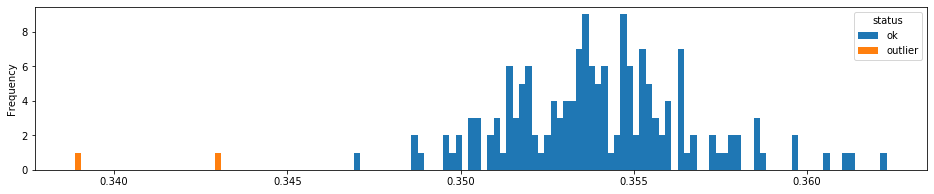

In [59]:
get_het_check().reset_index().pivot('index', 'status', 'het_rate').plot(kind='hist', bins=128, figsize=(16, 3))

In [70]:
%%timeop -o qc5-gen-outlier
get_het_check()\
    .pipe(lambda df: df[df['status'] == 'outlier'])\
    .pipe(lambda df: df[['FID', 'IID']].to_csv(data_dir + '/het_fail_ind.txt', index=False, sep=' '))
!cat $data_dir/het_fail_ind.txt | head

FID IID
1330 NA12342
1459 NA12874


In [71]:
%%timeop -o qc5-filter-outlier
%%bash -s $data_dir
set -e
cd $1 

#*# We don't need this step anymore since the file was written in the correct format already:
# Output of the command above: fail-het-qc.txt .
# When using our example data/the HapMap data this list contains 2 individuals (i.e., two individuals have a heterozygosity rate deviating more than 3 SD's from the mean).
# Adapt this file to make it compatible for PLINK, by removing all quotation marks from the file and selecting only the first two columns.
# sed 's/"// g' fail-het-qc.txt | awk '{print$1, $2}'> het_fail_ind.txt

# Remove heterozygosity rate outliers.
plink --bfile HapMap_3_r3_9 --remove het_fail_ind.txt --make-bed --out HapMap_3_r3_10

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_10.log.
Options in effect:
  --bfile HapMap_3_r3_9
  --make-bed
  --out HapMap_3_r3_10
  --remove het_fail_ind.txt

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
165 people (81 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
--remove: 163 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 110 founders and 53 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.998071.
1073226 variants and 163 people pass filters and QC.
Among remaining phenot

### Step 6: Heterzygosity Filtering

In [2]:
%%timeop -o qc6-find-cryptic-relatives
%%bash -s $data_dir
set -e
cd $1 
### step 6 ###

# It is essential to check datasets you analyse for cryptic relatedness.
# Assuming a random population sample we are going to exclude all individuals above the pihat threshold of 0.2 in this tutorial.

#*# The 3 commands below are information but not necessary for the pipeline so they can be skipped
# Check for relationships between individuals with a pihat > 0.2.
# plink --bfile HapMap_3_r3_10 --extract indepSNP.prune.in --genome --min 0.2 --out pihat_min0.2

# The HapMap dataset is known to contain parent-offspring relations. 
# The following commands will visualize specifically these parent-offspring relations, using the z values. 
# awk '{ if ($8 >0.9) print $0 }' pihat_min0.2.genome>zoom_pihat.genome

# Generate a plot to assess the type of relationship.
# Rscript --no-save Relatedness.R

# The generated plots show a considerable amount of related individuals (explentation plot; PO = parent-offspring, UN = unrelated individuals) in the Hapmap data, this is expected since the dataset was constructed as such.
# Normally, family based data should be analyzed using specific family based methods. In this tutorial, for demonstrative purposes, we treat the relatedness as cryptic relatedness in a random population sample.
# In this tutorial, we aim to remove all 'relatedness' from our dataset.
# To demonstrate that the majority of the relatedness was due to parent-offspring we only include founders (individuals without parents in the dataset).

#*# This will keep founders and remove non-founders
plink --bfile HapMap_3_r3_10 --filter-founders --make-bed --out HapMap_3_r3_11

# Now we will look again for individuals with a pihat >0.2.
plink --bfile HapMap_3_r3_11 --extract indepSNP.prune.in --genome --min 0.2 --out pihat_min0.2_in_founders
# The file 'pihat_min0.2_in_founders.genome' shows that, after exclusion of all non-founders, only 1 individual pair with a pihat greater than 0.2 remains in the HapMap data.
# This is likely to be a full sib or DZ twin pair based on the Z values. Noteworthy, they were not given the same family identity (FID) in the HapMap data.

# For each pair of 'related' individuals with a pihat > 0.2, we recommend to remove the individual with the lowest call rate. 
plink --bfile HapMap_3_r3_11 --missing
# Use an UNIX text editor (e.g., vi(m) ) to check which individual has the highest call rate in the 'related pair'. 

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_11.log.
Options in effect:
  --bfile HapMap_3_r3_10
  --filter-founders
  --make-bed
  --out HapMap_3_r3_11

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
163 people (79 males, 84 females) loaded from .fam.
110 phenotype values loaded from .fam.
53 people removed due to founder status (--filter-founders).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 110 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.998025.
1073226 variants and 110 people pass filters and QC.
A

Now there is a file containing highly related individuals (two individuals per row) and a separate file containing call rates for all indvidiuals.  

The tutorial again suggests that something be done manually but this is instead automated below.  Original commands/comments:

```bash
# Generate a list of FID and IID of the individual(s) with a Pihat above 0.2, to check who had the lower call rate of the pair.
# In our dataset the individual 13291  NA07045 had the lower call rate.
vi 0.2_low_call_rate_pihat.txt
i 
13291  NA07045
# Press esc on keyboard!
:x
# Press enter on keyboard
# In case of multiple 'related' pairs, the list generated above can be extended using the same method as for our lone 'related' pair.
```

Corresponding python code:

In [18]:
# Show the pairs of individuals with high genetic similarity generated above
df_cr = pd.read_csv(osp.join(data_dir, 'pihat_min0.2_in_founders.genome'), sep='\s+')
df_cr

,FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
0,13291,NA07045,1454,NA12813,UN,NaN,0.2572,0.5007,0.2421,0.4924,0,0.839777,1.0,9.7022


In [21]:
# Show the pairs of individuals above with corresponding call rates
m_cr = pd.read_csv(osp.join(data_dir, 'plink.imiss'), sep='\s+').set_index(['FID', 'IID'])['F_MISS'].to_dict()
df_crr = lambda: (
    df_cr.assign(
        I1CR=df_cr.set_index(['FID1', 'IID1']).index.map(m_cr),
        I2CR=df_cr.set_index(['FID2', 'IID2']).index.map(m_cr)
    )
)
df_crr()

,FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO,I1CR,I2CR
0,13291,NA07045,1454,NA12813,UN,NaN,0.2572,0.5007,0.2421,0.4924,0,0.839777,1.0,9.7022,0.002378,0.001814


In [27]:
# Generate space separated file of samples to remove where each line is "FID IID" of individual w/ lower call rate in related pairs
gen_line = lambda r, fid, iid: str(r[fid]) + ' ' + str(r[iid])
path = osp.join(data_dir, '0.2_low_call_rate_pihat.txt')
with open(path, 'w') as fd:
    df_crr()\
        .apply(lambda r: gen_line(r, 'FID2', 'IID2') if r['I1CR'] > r['I2CR'] else gen_line(r, 'FID1', 'IID2'), axis=1)\
        .map(lambda v: fd.write(v))
!cat $path

1454 NA12813

Now pass the file containing the samples to remove to PLINK:

In [28]:
%%timeop -o qc5-filter-cyrptic-relatives
%%bash -s $data_dir
set -e
cd $1 

# Delete the individuals with the lowest call rate in 'related' pairs with a pihat > 0.2 
plink --bfile HapMap_3_r3_11 --remove 0.2_low_call_rate_pihat.txt --make-bed --out HapMap_3_r3_12

PLINK v1.90b6.14 64-bit (7 Jan 2020)           www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to HapMap_3_r3_12.log.
Options in effect:
  --bfile HapMap_3_r3_11
  --make-bed
  --out HapMap_3_r3_12
  --remove 0.2_low_call_rate_pihat.txt

128535 MB RAM detected; reserving 64267 MB for main workspace.
1073226 variants loaded from .bim file.
110 people (55 males, 55 females) loaded from .fam.
110 phenotype values loaded from .fam.
--remove: 109 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 109 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.998023.
1073226 variants and 109 people pass filters and QC.
Among remai

And we're done!

In [ ]:
################################################################################################################################

# CONGRATULATIONS!! You've just succesfully completed the first tutorial! You are now able to conduct a proper genetic QC. 

# For the next tutorial, using the script: 2_Main_script_MDS.txt, you need the following files:
# - The bfile HapMap_3_r3_12 (i.e., HapMap_3_r3_12.fam,HapMap_3_r3_12.bed, and HapMap_3_r3_12.bim)
# - indepSNP.prune.in